In [1]:
import os

NUM_THREADS = "1"
os.environ["OMP_NUM_THREADS"] = NUM_THREADS
os.environ["OPENBLAS_NUM_THREADS"] = NUM_THREADS
os.environ["MKL_NUM_THREADS"] = NUM_THREADS
os.environ["VECLIB_MAXIMUM_THREADS"] = NUM_THREADS
os.environ["NUMEXPR_NUM_THREADS"] = NUM_THREADS

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import cluster
import numpy as np

from kneed import KneeLocator

from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances_argmin
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()
min_max_scaler= MinMaxScaler()

sns.set(style="whitegrid")

C:\Users\garik\miniconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

In [19]:
def find_optimal_number_of_cluster(group, k_max):
    if type(group) == pd.core.frame.DataFrame:
        group = np.array(group.values.tolist())
    if type(group) == []:
         group = np.array(group)
    scaled_features = scaler.fit_transform(group)
    kmeans_kwargs = {
        "init": "random",
        "n_init": 10,
        "max_iter": 150,
        "random_state": 42,
    }
    sse = []
    for k in range(1,k_max):
        kmeans = cluster.KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(scaled_features)
        sse.append(kmeans.inertia_)
    kl = KneeLocator(range(1, k_max), sse, curve="convex", direction="decreasing")
    return kl.elbow, sse

In [60]:
def normalize(df):
    df_normalized = min_max_scaler.fit_transform(df.drop(["country"], axis=1))
    df_normalized = pd.DataFrame(df_normalized, columns=df.columns[1:], index=df.index)
    df_normalized.insert(0, "country", df.country.to_list())
    return df_normalized

### NORMALIZE

In [65]:
raw_data = pd.read_csv('dataset/Country-data.csv')
df = raw_data.copy()
df_normalized = normalize(df)

In [66]:
display(df_normalized)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,0.426485,0.049482,0.358608,0.257765,0.008047,0.126144,0.475345,0.736593,0.003073
1,Albania,0.068160,0.139531,0.294593,0.279037,0.074933,0.080399,0.871795,0.078864,0.036833
2,Algeria,0.120253,0.191559,0.146675,0.180149,0.098809,0.187691,0.875740,0.274448,0.040365
3,Angola,0.566699,0.311125,0.064636,0.246266,0.042535,0.245911,0.552268,0.790221,0.031488
4,Antigua and Barbuda,0.037488,0.227079,0.262275,0.338255,0.148652,0.052213,0.881657,0.154574,0.114242
...,...,...,...,...,...,...,...,...,...,...
162,Vanuatu,0.129503,0.232582,0.213797,0.302609,0.018820,0.063118,0.609467,0.370662,0.026143
163,Venezuela,0.070594,0.142032,0.192666,0.100809,0.127750,0.463081,0.854043,0.208202,0.126650
164,Vietnam,0.100779,0.359651,0.312617,0.460715,0.031200,0.150725,0.808679,0.126183,0.010299
165,Yemen,0.261441,0.149536,0.209447,0.197397,0.031120,0.257000,0.698225,0.555205,0.010299


In [67]:
Y_label = "child_mort"
X_label = "health"

group = df_normalized[[X_label,Y_label]]
X = np.array(group.values.tolist())
NUMBER_CLUSTER, sse = find_optimal_number_of_cluster(group, 11)

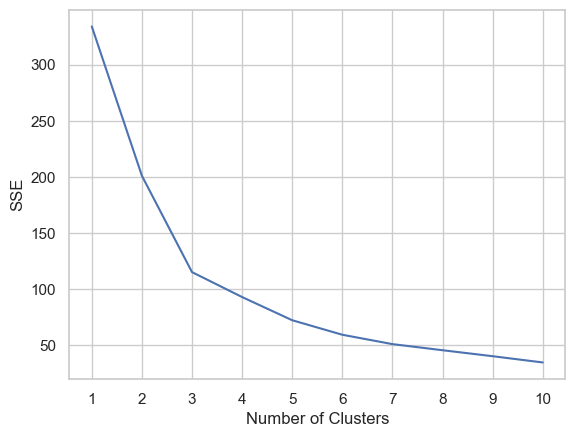

In [68]:
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [32]:
s_score = {} 
# Оцінка силуету вимірює, наскільки точка даних схожа на власний кластер порівняно з найближчим сусіднім кластером. Силует коливається від −1 до +1.
# Найкращим значенням є 1, а значення, близьке до 1, означає, що відстань вибірки до найближчого сусіднього кластера набагато більша, ніж відстань усередині кластера.
# 0 означає кластери, що перекриваються [2].
# Найгіршим значенням є -1, а значення, близьке до -1, означає, що зразок віднесено до неправильного кластера [2].
# Зверніть увагу, що коефіцієнт силуету визначається, лише якщо кількість кластерів становить принаймні 2 і не більше кількості вибірок мінус 1.
# Loop through the number of clusters

for i in range(2,11): # Note that the minimum number of clusters is 2
  # Fit kmeans clustering model for each cluster number
  kmeans = cluster.KMeans(n_clusters=i, random_state=0).fit(X)
  # Make prediction
  classes = kmeans.predict(X)
  # Calculate Silhouette score
  s_score[i] = (silhouette_score(X, classes)) 
  # Print the Silhouette score for each cluster number
  print(f'The silhouette score for {i} clusters is {s_score[i]:.3f}') 

The silhouette score for 2 clusters is 0.510
The silhouette score for 3 clusters is 0.590
The silhouette score for 4 clusters is 0.559
The silhouette score for 5 clusters is 0.572
The silhouette score for 6 clusters is 0.539
The silhouette score for 7 clusters is 0.494
The silhouette score for 8 clusters is 0.485
The silhouette score for 9 clusters is 0.479
The silhouette score for 10 clusters is 0.480


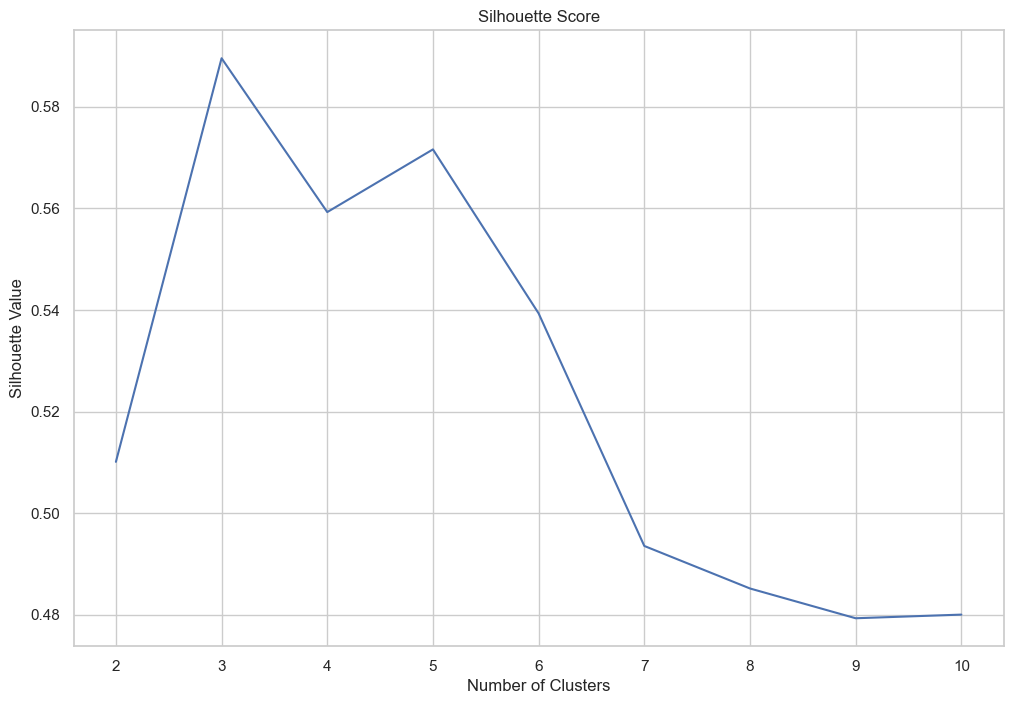

In [23]:
plt.figure(figsize=(12,8))
plt.plot(list(s_score.keys()),list(s_score.values()))
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Value')
plt.show()

In [39]:
def optimalK(data, nrefs=3, maxClusters=15):
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters)):
        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)
        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            
            # Fit to it
            km = cluster.KMeans(k)
            km.fit(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp
        # Fit cluster to original data and create dispersion
        km = cluster.KMeans(k)
        km.fit(data)
        
        origDisp = km.inertia_
        # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)
        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)
    return (gaps.argmax() + 1, resultsdf)  # Plus 1 because index of 0 means 1 cluster is optimal, index 2 = 3 clusters are optimal

C:\Users\garik\AppData\Local\Temp\ipykernel_4272\1326530502.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)
C:\Users\garik\AppData\Local\Temp\ipykernel_4272\1326530502.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)
C:\Users\garik\AppData\Local\Temp\ipykernel_4272\1326530502.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)
C:\Users\garik\AppData\Local\Temp\ipykernel_4272\1326530502.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Optimal k is:  10


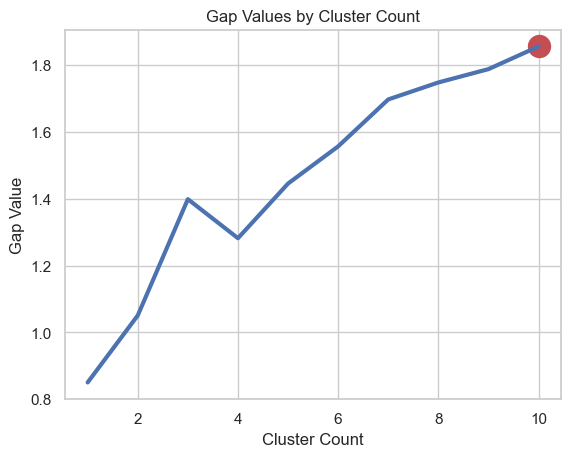

In [40]:
# Статистика розривів порівнює зміну дисперсії всередині кластера з рівномірним розподілом. 
# Значення великої статистики розриву означає, що кластеризація сильно відрізняється від рівномірного розподілу.
k, gapdf = optimalK(X, nrefs=3, maxClusters=11)
print('Optimal k is: ', k)
# Visualization
plt.plot(gapdf.clusterCount, gapdf.gap, linewidth=3)
plt.scatter(gapdf[gapdf.clusterCount == k].clusterCount, gapdf[gapdf.clusterCount == k].gap, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')
plt.show()

In [33]:
print("X: {} Y: {} Final Result Cluster: {}".format(X_label, Y_label, NUMBER_CLUSTER))

X: gdpp Y: child_mort Final Result Cluster: 3


In [69]:
KMeans_method=cluster.KMeans(init="k-means++", n_clusters=NUMBER_CLUSTER, n_init=10, random_state=24, max_iter=300)
SpectralClustering_method = cluster.SpectralClustering(n_clusters=NUMBER_CLUSTER, affinity='nearest_neighbors', assign_labels='kmeans')
dbscan = cluster.DBSCAN(eps=0.25)

centers, labels = find_clusters(X, NUMBER_CLUSTER, rseed=0)

labels_k_mean  = KMeans_method.fit(X).labels_
centers_k_mean = KMeans_method.fit(group).cluster_centers_

labels_spectral = SpectralClustering_method.fit_predict(X)

scaled_features = scaler.fit_transform(group)
dbscan.fit(scaled_features)

labels_dbscan = dbscan.labels_

df_normalized['find'] = labels
df_normalized['k-mean'] = labels_k_mean
df_normalized['spectral'] = labels_spectral
df_normalized['dbscan'] = labels_dbscan

In [70]:
labels_K_Mean = np.insert(np.array(df_normalized.loc[:,["k-mean","country"]].groupby("k-mean").count().values.tolist()).reshape(-1).astype(str), 0, "K-Mean")
labels_AlgoExp_Max = np.insert(np.array(df_normalized.loc[:,["find","country"]].groupby("find").count().values.tolist()).reshape(-1).astype(str), 0, "AlgoExp_Max")
labels_Spectral = np.insert(np.array(df_normalized.loc[:,["spectral","country"]].groupby("spectral").count().values.tolist()).reshape(-1).astype(str), 0, "Spectral")
labels_Dbscan = np.insert(np.array(df_normalized.loc[:,["dbscan","country"]].groupby("dbscan").count().values.tolist()).reshape(-1).astype(str), 0, "Dbscan")
print(labels_K_Mean, labels_AlgoExp_Max, labels_Spectral, labels_Dbscan, sep="\n")

['K-Mean' '77' '56' '34']
['AlgoExp_Max' '56' '34' '77']
['Spectral' '83' '52' '32']
['Dbscan' '46' '111' '5' '5']


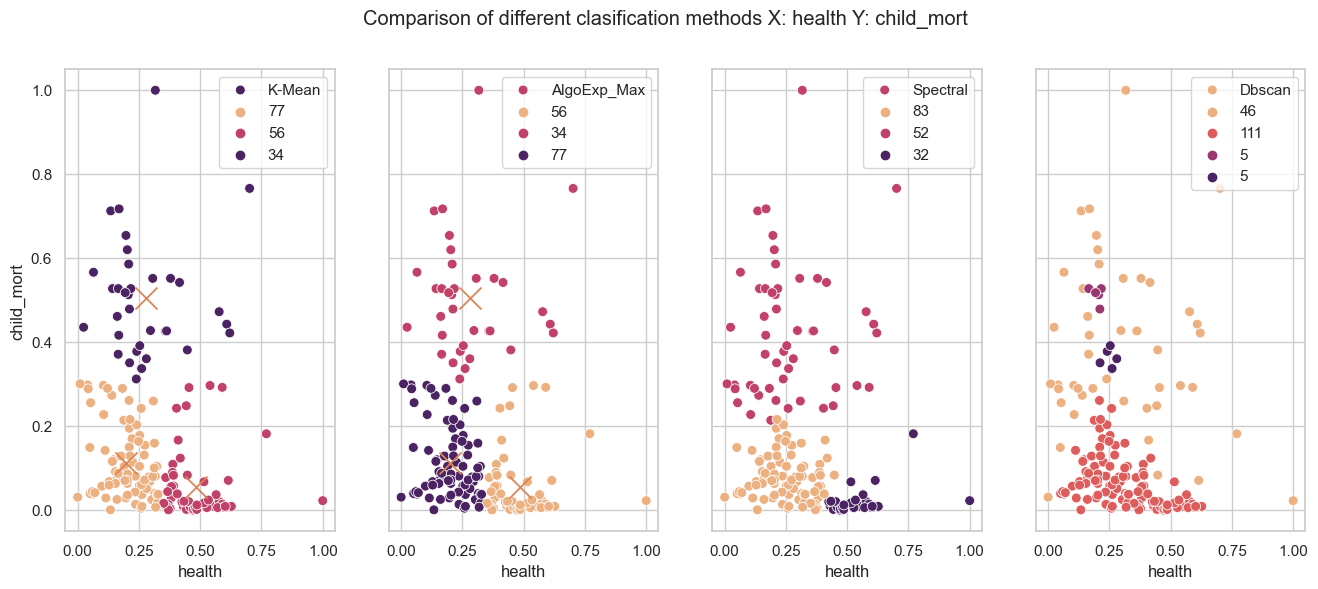

In [71]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 6), sharex=True, sharey=True)


sns.scatterplot(data=df_normalized, x=X_label, y=Y_label, hue="k-mean", s=50,alpha=1, palette="flare", ax=ax1)
sns.scatterplot(x=centers_k_mean[:, 0], y=centers_k_mean[:, 1], s=250, zorder=2, marker="x", ax=ax1, legend=None)
ax1.legend(labels=labels_K_Mean)

sns.scatterplot(data=df_normalized, x=X_label, y=Y_label, hue="find", s=50,alpha=1, palette="flare", ax=ax2)
sns.scatterplot(x=centers[:, 0], y=centers[:, 1], s=250, zorder=2, marker="x", ax=ax2, legend=None)
ax2.legend(labels=labels_AlgoExp_Max)

sns.scatterplot(data=df_normalized, x=X_label, y=Y_label, hue="spectral", s=50,alpha=1, palette="flare", ax=ax3)
ax3.legend(labels=labels_Spectral)

sns.scatterplot(data=df_normalized, x=X_label, y=Y_label, hue="dbscan", s=50,alpha=1, palette="flare", ax=ax4)
ax4.legend(labels=labels_Dbscan)

fig.suptitle("Сomparison of different clasification methods X: {} Y: {}".format(X_label, Y_label))
plt.savefig('img/{} clasification methods.jpg'.format(Y_label))

In [57]:
def result_def(df, target, limit=0):
    df = normalize(df)
    if limit==0: limit=len(df.columns)-2
    df_result = pd.DataFrame(df.country, columns=["country"])
    df_result[target]=df[target]
    
    fig, axes = plt.subplots(1, limit, figsize=(3*limit, 6))
    for index, y_label in enumerate(df.columns[1:limit+1]):
        print("iteration: {} x: {} target: {}".format(index+1, y_label, target))
        if target != y_label and df[y_label].dtypes != object:
            group = df[[y_label,target]]
            X = np.array(group.values.tolist())
            
            NUM_CLUSTER, see = find_optimal_number_of_cluster(X, 11)
            print("Count clusters: {}".format(NUM_CLUSTER))
            
            centers, labels = find_clusters(X, NUM_CLUSTER, rseed=0)
            key='cluster_'+y_label
            df_result[key] = labels
            df[key] = labels
            
            axes[index].get_xaxis().set_visible(False)
            sns.scatterplot(data=df, x=target, y=y_label, hue=key, s=50,alpha=0.45, palette="flare", ax=axes[index])
            sns.scatterplot(x=centers[:, 1], y=centers[:, 0], s=250, zorder=2, marker="x", ax=axes[index], palette=["black"]);
            sns.move_legend(axes[index], "upper center", ncol=2, frameon=False, bbox_to_anchor=(.5, 0), title=y_label)
            axes[index].set(ylabel=None)
            axes[index].label_outer()
    fig.suptitle("Сomparison of different features using Exp max method with X label: {}".format(target))
    plt.savefig('img/{} clasification features.jpg'.format(target))
    df_result.to_csv('result_cluster.csv', encoding='utf-8', index=False)

iteration: 1 x: child_mort target: gdpp
Count clusters: 3
iteration: 2 x: exports target: gdpp
Count clusters: 4
iteration: 3 x: health target: gdpp
Count clusters: 3
iteration: 4 x: imports target: gdpp
Count clusters: 4
iteration: 5 x: income target: gdpp
Count clusters: 3
iteration: 6 x: inflation target: gdpp
Count clusters: 4
iteration: 7 x: life_expec target: gdpp
Count clusters: 3
iteration: 8 x: total_fer target: gdpp
Count clusters: 3


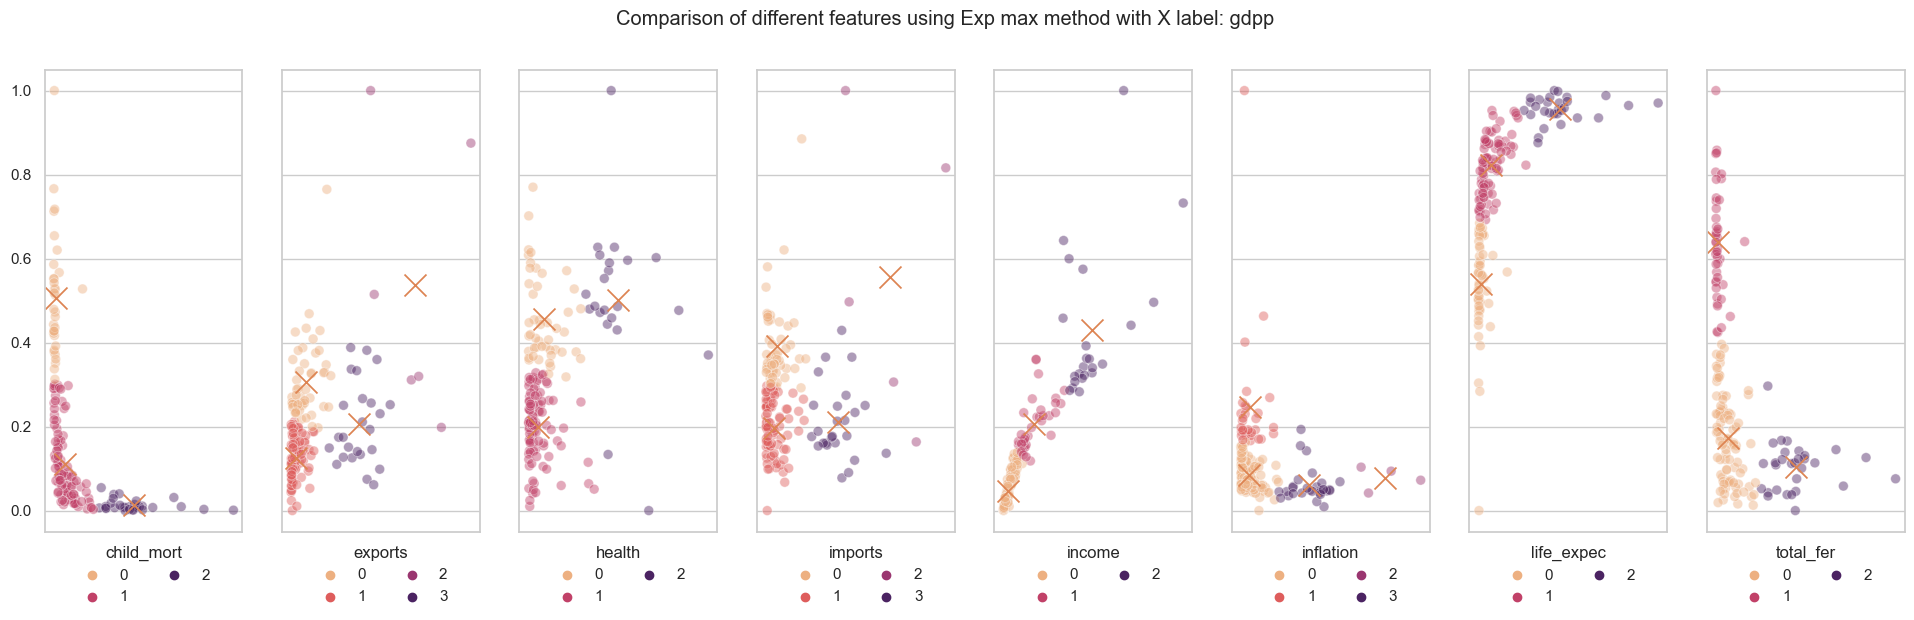

In [55]:
df = pd.read_csv('dataset/Country-data.csv')
result_def(df.copy(), "gdpp")

In [49]:
df = pd.read_csv('result_cluster.csv')

In [50]:
df.head()

,country,gdpp,cluster_child_mort,cluster_exports,cluster_health,cluster_imports,cluster_income,cluster_inflation,cluster_life_expec,cluster_total_fer
0,Afghanistan,0.003073,0,1,0,1,0,0,0,1
1,Albania,0.036833,1,1,1,1,0,0,1,0
2,Algeria,0.040365,1,1,1,1,0,1,1,0
3,Angola,0.031488,0,0,1,1,0,1,0,1
4,Antigua and Barbuda,0.114242,1,0,1,0,1,0,1,0


In [51]:
df_result = df[(df.cluster_child_mort == 0)
               &(df.cluster_income==0)
               &(df.cluster_inflation==1)].sort_values("gdpp").reset_index(drop=True)

In [52]:
df_result

,country,gdpp,cluster_child_mort,cluster_exports,cluster_health,cluster_imports,cluster_income,cluster_inflation,cluster_life_expec,cluster_total_fer
0,"Congo, Dem. Rep.",0.000983,0,1,0,1,0,1,0,1
1,Sierra Leone,0.001604,0,1,0,1,0,1,0,1
2,Guinea,0.003980,0,1,1,1,0,1,0,1
3,Mauritania,0.009249,0,0,1,0,0,1,1,1
4,Ghana,0.010299,0,1,1,1,0,1,0,1
5,Zambia,0.011731,0,1,1,1,0,1,0,1
6,Sudan,0.011921,0,1,1,1,0,1,0,1
7,Nigeria,0.020035,0,1,1,1,0,1,0,1
8,Angola,0.031488,0,0,1,1,0,1,0,1
